# Udacity BAND SQL follow up project

## Introduction

This small EDA project is a follow up of SQL project from Udacity Business Analytics Nanodegree program (BAND). Original BAND project requires search through chinook musical store database using DB Browser for SQLite, and student has to submit for review 4 different SQL queries for 4 different questions, and than prepare 4 related visualizations using Google Slides.

In the follow up I prepared a version with slightly different questions, but interactions with chinook db happen in the python programming environment using sqlite3 module. Results of queries are saved as pandas DataFrame, that allows quickly get a descriptive statistics for quantitative variables. Visualizations are done with seaborn.

In [13]:
import sqlite3

import pandas as pd
import seaborn as snAnalytics

In [2]:
conn = sqlite3.connect('chinook.db')

In [3]:
curs = conn.cursor()

In [22]:
# convinience function, take sql query as a string variable and either return DataFrame or print database error message
def df_from_query(query):
    try:
        return pd.DataFrame.from_records(curs.execute(query).fetchall())
    except sqlite3.DatabaseError as err:       
        print("Error: ", err)

## Albums pricing 

The first question considers expensive are albums available in the music store. Album' price is defined as total price of all songs included. Also, it is interesting to take a look on descriptive statistics of album pricing.

In [23]:
query01 = """
SELECT
  Album.Title,
  SUM(UnitPrice) album_price
FROM Track
JOIN Album
  ON Track.AlbumId = Album.AlbumId
GROUP BY Album.Title
ORDER BY 2 DESC;
"""
albums_price = df_from_query(query01)
albums_price.columns = ['album_title','price']

In [24]:
albums_price.head()

,album_title,price
0,Greatest Hits,56.43
1,"Lost, Season 3",51.74
2,"Lost, Season 1",49.75
3,"The Office, Season 3",49.75
4,"Battlestar Galactica (Classic), Season 1",47.76


In [7]:
albums_price.describe()

,price
count,347.000000
mean,10.607983
std,8.755274
min,0.990000
25%,1.980000
50%,10.890000
75%,13.860000
max,56.430000


In [8]:
albums_price.tail()

,album_title,price
342,Un-Led-Ed,0.99
343,Vivaldi: The Four Seasons,0.99
344,Wagner: Favourite Overtures,0.99
345,Weill: The Seven Deadly Sins,0.99
346,Worlds,0.99


Obviously, there are a lot of one-song albums as $0.99 price is a price of one song.

In [12]:
print(f'# of one-song albums = {albums_price[albums_price.price==0.99].shape[0]}')

# of one-song albums = 80


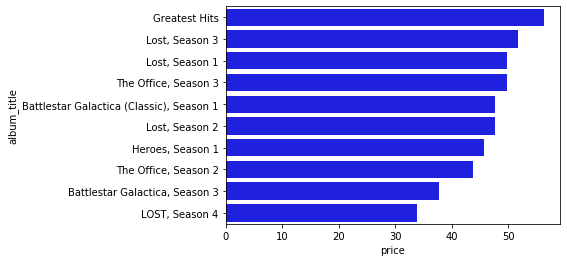

In [21]:
sn.barplot(x="price",y="album_title",data=albums_price[:10],ci=None, color="b")

It is interesting to notice that top-10 of most expensive albums is dominated by TV shows tracks collections, and there is only one exception.

Greatest Hits author:

In [30]:
query_GH_author = """
SELECT Title, Name
FROM Album
JOIN Artist ON Album.ArtistId = Artist.ArtistId
WHERE Title = "Greatest Hits"
"""
res = curs.execute(query_GH_author).fetchall()
print(f'{res[0][1]} is the author of most expensive album titled {res[0][0]}.')

Lenny Kravitz is the author of most expensive album titled Greatest Hits.


## Some questions around average track length

This section originated from Udacity proposed model question: how many tracks in DB are longer than average? I transformed that in two following question.

### Artists created most of the longer than average tracks among available in the music store

In [36]:
query02 = """
SELECT
  Artist.Name,
  COUNT(TrackId) AS n_long_tracks
FROM Track
JOIN Album
  ON Track.AlbumId = Album.AlbumId
JOIN Artist
  ON Album.ArtistId = Artist.ArtistId
WHERE Milliseconds > (SELECT
  AVG(Milliseconds) AS avg_track_len
FROM Track)
GROUP BY Artist.Name
ORDER BY n_long_tracks DESC;
"""
artists_longs = df_from_query(query02)
artists_longs.columns = ['artist','n_of_long_tracks']
artists_longs.head()

,artist,n_of_long_tracks
0,Lost,91
1,Iron Maiden,60
2,The Office,53
3,Metallica,38
4,Led Zeppelin,28


In [37]:
artists_longs.describe()

,n_of_long_tracks
count,80.000000
mean,6.175000
std,14.335735
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,91.000000


Because we asked about artists who created at least 1 track longer than average, the min value for number of longer-than-average tracks equals to 1. It it interesting that median equals to 1 as well, and 75 percentile equals only to 3, while mean equals to 6 and max is 91. 

So the distribution of that variable is heavily left-skewed and it is obvious without making graph.

In [38]:
artists_longs.tail()

,artist,n_of_long_tracks
75,The Rolling Stones,1
76,The Tea Party,1
77,The Who,1
78,Toquinho & Vinícius,1
79,Vinícius De Moraes,1


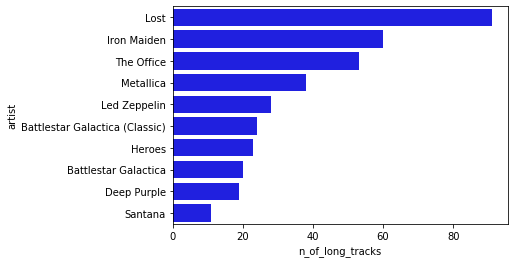

In [39]:
sn.barplot(x="n_of_long_tracks",y="artist",data=artists_longs[:10],ci=None, color="b")

Apparently, Lost soundtracks are longer than average among presented in the music store.

### Fraction of longer than average tracks in overall artist' body of work presented in the music store for top artists from previous list

In [40]:
query03 = """
WITH selected_artists
AS (SELECT
  Artist.Name AS artist_names,
  COUNT(TrackId) AS n_long_tracks
FROM Track
JOIN Album
  ON Track.AlbumId = Album.AlbumId
JOIN Artist
  ON Album.ArtistId = Artist.ArtistId
WHERE Milliseconds > (SELECT
  AVG(Milliseconds) AS avg_track_len
FROM Track)
GROUP BY Artist.Name
ORDER BY n_long_tracks DESC)
SELECT
  artist_names,
  CAST(selected_artists.n_long_tracks AS float) / CAST(COUNT(Track.TrackId) AS float) AS fraction_of_long_tracks,
  selected_artists.n_long_tracks
FROM Track
JOIN Album
  ON Track.AlbumId = Album.AlbumId
JOIN Artist
  ON Album.ArtistId = Artist.ArtistId
JOIN selected_artists
  ON Artist.Name = selected_artists.artist_names
GROUP BY artist_names
ORDER BY 3 DESC;
"""
frac = df_from_query(query03)
frac.columns = ['artist','fraction','n_long_tracks']
frac.head()

,artist,fraction,n_long_tracks
0,Lost,0.989130,91
1,Iron Maiden,0.281690,60
2,The Office,1.000000,53
3,Metallica,0.339286,38
4,Led Zeppelin,0.245614,28


In [42]:
frac.describe()

,fraction,n_long_tracks
count,80.000000,80.000000
mean,0.325339,6.175000
std,0.380445,14.335735
min,0.014815,1.000000
25%,0.062500,1.000000
50%,0.125000,1.000000
75%,0.430556,3.000000
max,1.000000,91.000000


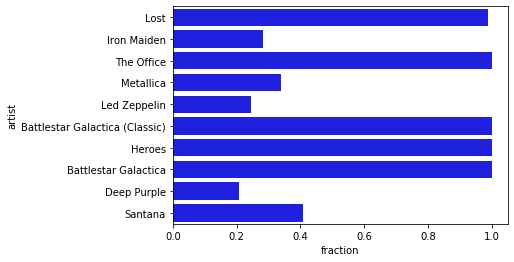

In [43]:
sn.barplot(x="fraction",y="artist",data=frac[:10],ci=None, color="b")

That graph supports a hypothesis that TV shows tracks are longer than average in general. Also, Santana, who doesn't have the biggest number of long tracks, has a biggest fraction of long tracks among human artist (non TV shows)

## Track sales per genre in USA in 2011

In [44]:
query04 = """
SELECT
  Genre.Name genre,
  SUM(InvoiceLine.UnitPrice * InvoiceLine.Quantity) revenue
FROM InvoiceLine
JOIN Track
  ON InvoiceLine.TrackId = Track.TrackId
JOIN Genre
  ON Track.GenreId = Genre.GenreId
JOIN Invoice
  ON InvoiceLine.InvoiceId = Invoice.InvoiceId
WHERE InvoiceDate BETWEEN '2011-01-01' AND '2011-12-31'
AND BillingCountry = "USA"
GROUP BY genre
ORDER BY revenue DESC;
"""
sales = df_from_query(query04)
sales.columns = ['genre', 'revenue']
sales.head()

,genre,revenue
0,Latin,30.69
1,Rock,25.74
2,TV Shows,7.96
3,R&B/Soul,6.93
4,Reggae,5.94


In [45]:
sales.describe()

,revenue
count,13.000000
mean,7.923846
std,9.277698
min,0.990000
25%,2.970000
50%,4.950000
75%,6.930000
max,30.690000


In [46]:
sales.tail()

,genre,revenue
8,Classical,3.96
9,Easy Listening,2.97
10,Comedy,1.99
11,Soundtrack,1.98
12,Metal,0.99


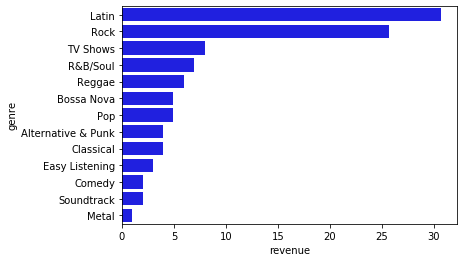

In [47]:
sn.barplot(x="revenue",y="genre",data=sales,ci=None, color="b")

So it is clear that in 2011 Latin and Rock dominated sales in the USA.